### Part One: Fitting Models

In [77]:
import pandas as pd
ha_data = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

# Data cleaning
good_cols = ha_data.isna().sum() < 100
ha_data = ha_data.loc[:,good_cols]
ha_data = ha_data.dropna()

print(ha_data)

     age  sex  cp  trtbps  chol  restecg  thalach  output
0     63    1   3     145   233        0      150       1
1     37    1   2     130   250        1      187       1
2     56    1   1     120   236        1      178       1
3     57    0   0     120   354        1      163       1
4     57    1   0     140   192        1      148       1
..   ...  ...  ..     ...   ...      ...      ...     ...
268   59    1   0     164   176        0       90       0
269   57    0   0     140   241        1      123       0
270   45    1   3     110   264        1      132       0
271   68    1   0     144   193        1      141       0
272   57    0   1     130   236        0      174       0

[273 rows x 8 columns]


In [106]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
from plotnine import *

In [79]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ha_data.drop('output', axis=1))
X = pd.DataFrame(X_scaled, columns=ha_data.columns[:-1])
y = ha_data['output']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
def fit_and_plot_roc(model, param_grid, model_name):
    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    #Best hyperparameters
    print(f'Best hyperparameters for {model_name}: {grid_search.best_params_}')
    
    # Calculate ROC Curve
    roc_auc = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    print(f'{model_name} - Cross-validated ROC AUC: {roc_auc:.4f}')
    
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    #Confusion matrix
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print(f'\nConfusion Matrix - {model_name}:\n{cm}\n')
    
    # Interpret coefficients
    if hasattr(best_model, 'coef_'):
        feature_names = X.columns
        coefficients = best_model.coef_[0]
        print(f'\nCoefficients - {model_name}:')
        for feature, coef in zip(feature_names, coefficients):
            print(f'{feature}: {coef}')
        print('\n')

Best hyperparameters for KNN: {'n_neighbors': 7}
KNN - Cross-validated ROC AUC: 0.8460


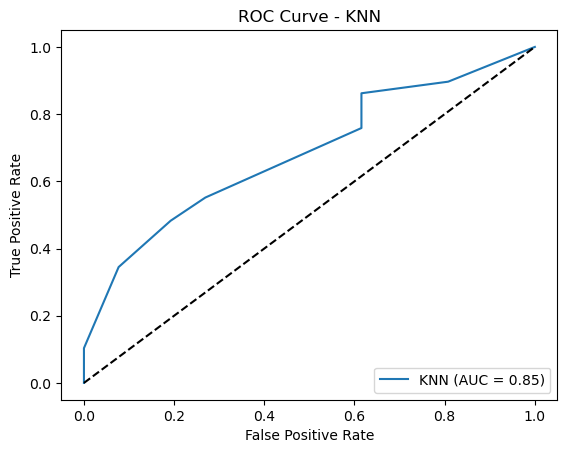


Confusion Matrix - KNN:
[[19  7]
 [13 16]]



In [88]:
# Q1: KNN
knn_model = KNeighborsClassifier()
knn_param_grid = {'n_neighbors': [3, 5, 7]}
fit_and_plot_roc(knn_model, knn_param_grid, 'KNN')

Best hyperparameters for Logistic Regression: {'C': 10}
Logistic Regression - Cross-validated ROC AUC: 0.8848


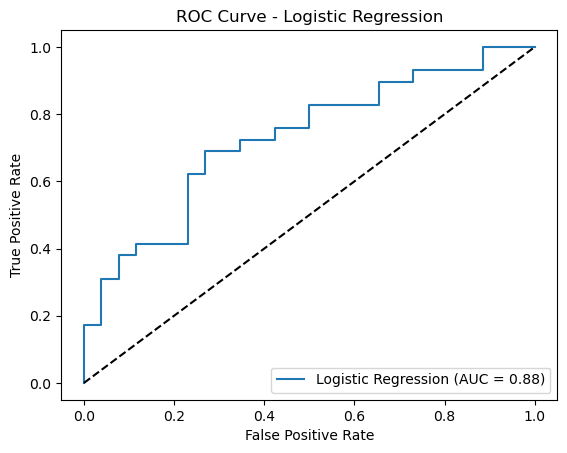


Confusion Matrix - Logistic Regression:
[[20  6]
 [14 15]]


Coefficients - Logistic Regression:
age: -0.29000418972248604
sex: -1.2325444178635696
cp: 0.8861377913945483
trtbps: -0.27435586402773815
chol: -0.2714685397841656
restecg: 0.04127122640832623
thalach: 1.3425326272700238




In [89]:
# Q2: Logistic Regression
logreg_model = LogisticRegression()
logreg_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
fit_and_plot_roc(logreg_model, logreg_param_grid, 'Logistic Regression')

Best hyperparameters for Decision Tree: {'max_depth': 3}
Decision Tree - Cross-validated ROC AUC: 0.8277


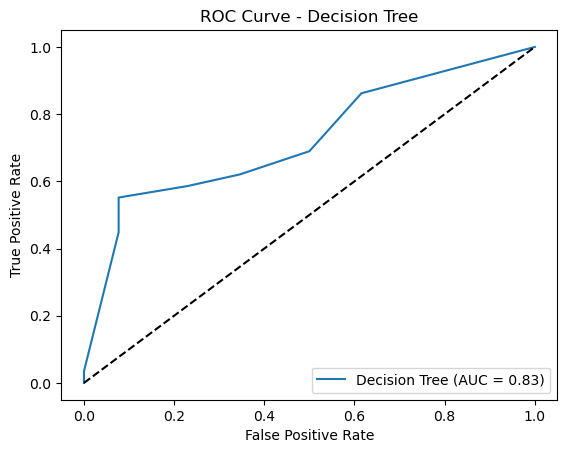


Confusion Matrix - Decision Tree:
[[17  9]
 [11 18]]



In [90]:
# Q3: Decision Tree
dt_model = DecisionTreeClassifier()
dt_param_grid = {'max_depth': [3, 5, 7, 10]}
fit_and_plot_roc(dt_model, dt_param_grid, 'Decision Tree')

#### Q4: Interpretation

Thalach - the maximum heart rate achieved during exercise - is the most important predictor of heart attack according to the logistic regression model. The next most important variable is sex, where the log odds of having a heart attack for males compared to females decreases by approximately 1.23 (which seems fishy considering males are generally more prone to heart attacks). The third most important predictor of heart attack is chest pain type. For a one-value increase in chest pain type, the log-odds of having a heart attack increase by approximately 0.89.

### Part Two: Metrics

In [107]:
from sklearn.model_selection import cross_val_predict
import numpy as np

# Function to compute metrics
def compute_metrics(model, model_name):

    y_pred_prob = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()

    # Precision
    precision = tp / (tp + fp)
    
    # Recall/Sensitivity - true positive rate
    recall = tp / (tp + fn)
    
    # Specificity - true negative rate
    specificity = tn / (tn + fp)
    
    print(f'{model_name} Metrics (Cross-validated):')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Specificity: {specificity:.4f}\n')

In [92]:
# Q1: KNN
compute_metrics(knn_model, 'KNN')

KNN Metrics (Cross-validated):
Precision: 0.7360
Recall: 0.7863
Specificity: 0.6733



In [93]:
# Q2: Logistic Regression
compute_metrics(logreg_model, 'Logistic Regression')

Logistic Regression Metrics (Cross-validated):
Precision: 0.7823
Recall: 0.8291
Specificity: 0.7327



In [94]:
# Q3: Decision Tree
compute_metrics(dt_model, 'Decision Tree')

Decision Tree Metrics (Cross-validated):
Precision: 0.7008
Recall: 0.7607
Specificity: 0.6238



### Part Three: Discussion

##### Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

In this case, we want to minimize false negatives to reduce the risk of misclassifying someone as low risk when they later experience a heart attack. A model with high recall/sensitivity can help avoid missing patients who are at risk. The recommended model with the highest recall is the Logistic Regression model. In predicting future observations I would expect the model to return a similarly high recall score.

##### Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.
In a situation where bed space is limited we want to minimize false positives, maximizing specificity. Based on the results Logistic Regression has the highest specificity and would be the best model for this case. When predicting future observations I would expect this model to return a similarly high specificity.

##### Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.
Here there is greater emphasis on the importance of individual features (biological measures), and feature importance from models like Logistic Regression or Decision Tree can provide insights. Coefficients can be evaluated and assessed from the Logistic Regression model indicating the direction and strength of the association between each biological measure and the likelihood of a heart attack. The Decision Tree model can similarly visually point to the most important features that contribute to the risk of heart attack from the splits in the data.

##### Q4: The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.
A balance between precision and recall would be helpful for the hospital, therefore the F1 score, which considers both precision and recall would be most helpful in assessing the accuracy in which new doctors can accurately diagnose patients. The Logistic Regression model has a good balance between precision and recall and would be best suited in comparing the diagnostic predictions. In future predictions, Logistic Regression is expected to provide a balanced F1 score, pointing to a fair comparison between the diagnoses of new doctors and the model predictions.

### Part Four & Five: Validation & Cohen's Kappa

In [95]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [96]:
X_scaled = scaler.fit_transform(ha_validation.drop('output', axis=1))
X_val = pd.DataFrame(X_scaled, columns=ha_validation.columns[:-1])
y_val = ha_validation['output']

In [108]:
from sklearn.metrics import cohen_kappa_score

# Fit model, hyperparameter tuning, calculate ROC AUC, plotROC, and compute Cohen's Kappa
def fit_and_plot_roc_with_kappa(model, param_grid, model_name, X_val, y_val):
    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Best hyperparameters
    print(f'Best hyperparameters for {model_name}: {grid_search.best_params_}')
    
    # Calculate ROC Curve
    roc_auc = cross_val_score(best_model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    print(f'{model_name} - Cross-validated ROC AUC: {roc_auc:.4f}')
    
    y_pred_prob = best_model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    
    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

    # Confusion matrix
    y_pred = best_model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    print(f'\nConfusion Matrix - {model_name}:\n{cm}\n')
    
    # Interpret coefficients
    if hasattr(best_model, 'coef_'):
        feature_names = X.columns
        coefficients = best_model.coef_[0]
        print('\nCoefficients:')
        for feature, coef in zip(feature_names, coefficients):
            print(f'{feature}: {coef}')
        print('\n')
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_val, y_pred)
    print(f'{model_name} - Cohen\'s Kappa: {kappa:.4f}\n')
    
    # Precision and recall
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    print(f'{model_name} - Precision: {precision:.4f}')
    print(f'{model_name} - Recall: {recall:.4f}\n')

Best hyperparameters for KNN: {'n_neighbors': 7}
KNN - Cross-validated ROC AUC: 0.8460


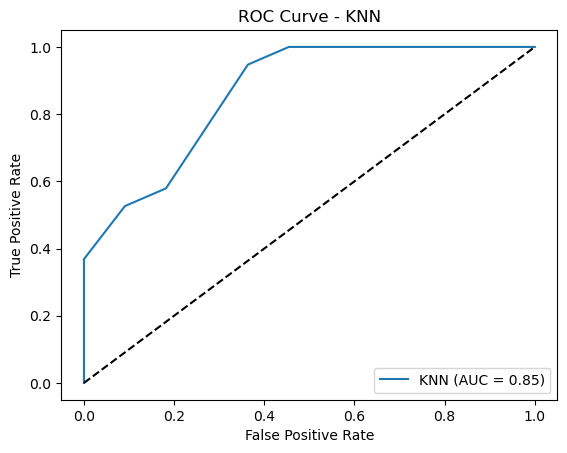


Confusion Matrix - KNN:
[[ 9  2]
 [ 8 11]]

KNN - Cohen's Kappa: 0.3562

KNN - Precision: 0.8462
KNN - Recall: 0.5789



In [109]:
# Q1: KNN
fit_and_plot_roc_with_kappa(knn_model, knn_param_grid, 'KNN', X_val, y_val)

Best hyperparameters for Logistic Regression: {'C': 10}
Logistic Regression - Cross-validated ROC AUC: 0.8848


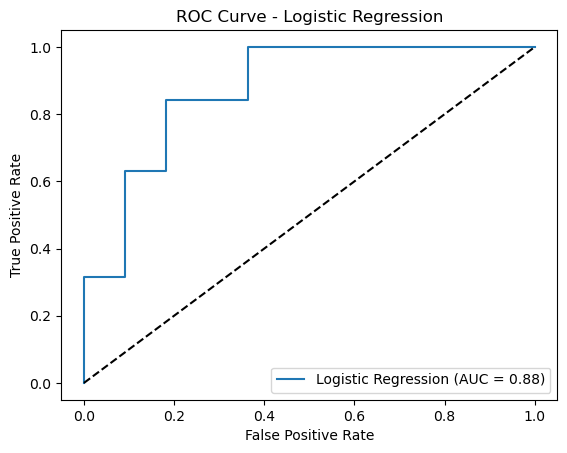


Confusion Matrix - Logistic Regression:
[[ 9  2]
 [ 4 15]]


Coefficients:
age: -0.29000418972248604
sex: -1.2325444178635696
cp: 0.8861377913945483
trtbps: -0.27435586402773815
chol: -0.2714685397841656
restecg: 0.04127122640832623
thalach: 1.3425326272700238


Logistic Regression - Cohen's Kappa: 0.5853

Logistic Regression - Precision: 0.8824
Logistic Regression - Recall: 0.7895



In [110]:
# Q2: Logistic Regression
fit_and_plot_roc_with_kappa(logreg_model, logreg_param_grid, 'Logistic Regression', X_val, y_val)

Best hyperparameters for Decision Tree: {'max_depth': 3}
Decision Tree - Cross-validated ROC AUC: 0.8277


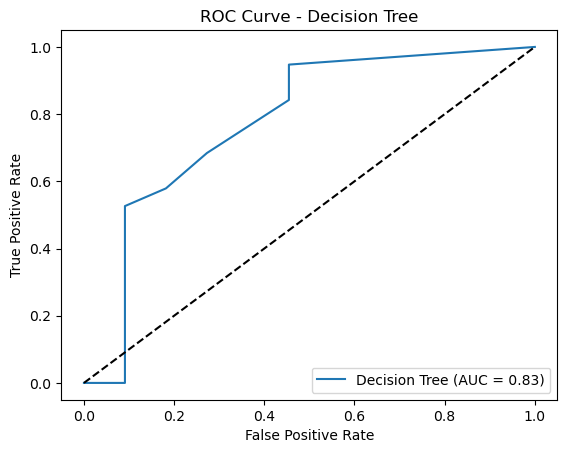


Confusion Matrix - Decision Tree:
[[ 8  3]
 [ 6 13]]

Decision Tree - Cohen's Kappa: 0.3891

Decision Tree - Precision: 0.8125
Decision Tree - Recall: 0.6842



In [111]:
# Q3: Decision Tree
fit_and_plot_roc_with_kappa(dt_model, dt_param_grid, 'Decision Tree', X_val, y_val)

#### Part 4 Discussion: 

The measure of model success, estimated through cross-validated metrics, aligns with the performance of the models fitting on the validation set. This consistency suggests that the models are performing as expected and are not overfitting to the training data. 

#### Part 5 Discussion: 

Cohen's Kappa is a measure of inter-rater agreement, which assesses the agreement between predicted and actual classes while accounting for chance agreement. It is particularly useful when dealing with imbalanced datasets. In situations where accuracy alone may be misleading (especially in imbalanced datasets), Cohen's Kappa provides a better understanding by considering both the observed agreement and the agreement expected by chance.


The Kappa scores for all models are positive, indicating better than chance agreement. Kappa values above 0.6 are generally considered substantial agreement, which no model achieved. There was fair to moderate agreement across the models, making me only slightly less confident in the model performance, but still confident in their ability to accurately predict future observations.